In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.feature_extraction import DictVectorizer

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, precision_score, recall_score, make_scorer
from sklearn.metrics import brier_score_loss

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate


import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm


import xml.etree.ElementTree as ET
import json

import Feature_Extraction as fe

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ga75xoh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
root = ET.parse('data/RTE1_dev1_3ways.xml').getroot()
r1 = []
r2 = []
y = []
for el in list(root):
    label = el.get('entailment')
    if label == 'YES':
        y.append(1)
    elif label == 'NO':
        y.append(1)
    else:
        y.append(-1)
    r1.append(list(el)[0].text)
    r2.append(list(el)[1].text)
    
root = ET.parse('data/RTE1_dev2_3ways.xml').getroot()
for el in list(root):
    label = el.get('entailment')
    if label == 'YES':
        y.append(1)
    elif label == 'NO':
        y.append(1)
    else:
        y.append(-1)
    r1.append(list(el)[0].text)
    r2.append(list(el)[1].text)
    
r1t = []
r2t = []
yt = []
root = ET.parse('data/RTE1_test_3ways.xml').getroot()
for el in list(root):
    label = el.get('entailment')
    if label == 'YES':
        yt.append(1)
    elif label == 'NO':
        yt.append(1)
    else:
        y.append(-1)
    r1t.append(list(el)[0].text)
    r2t.append(list(el)[1].text)

In [3]:
ra1 = r1 + r1t
ra2 = r2 + r2t
ya = y + yt

In [4]:
x = []
for i in range(len(ra1)):
    x.append(fe.createFBagRootSUBJOBJ(ra1[i], ra2[i]))

In [6]:
x[0]

{'M_1': 'unknown',
 'root_1': 'trade',
 'M_2': 'unknown',
 'root_2': 'rise',
 'subj11': 'oil',
 'subj12': 'NONE',
 'obj11': 'delivery',
 'obj12': '37.80',
 'subj21': 'price',
 'subj22': 'NONE',
 'obj21': '37.80',
 'obj22': 'barrel'}

In [7]:
vec = DictVectorizer()
xx = vec.fit_transform(x).toarray()

In [10]:
print(xx.shape)
xx[0]

(1367, 5437)


array([0., 0., 0., ..., 0., 0., 0.])

In [11]:
yy = []
for val in ya:
    if val > 0:
        yy.append(1)
    else:
        yy.append(0)

In [12]:
import warnings
warnings.filterwarnings('ignore')


kfold = 10
cv = RepeatedStratifiedKFold(n_splits=kfold, n_repeats=5)

#train_sizes = [50, 100, 150, 200, 250, 300, 350, 400,  450, 500]
train_sizes = range(50, len(yy), 50)

#scoring =  {'brier_score_loss': make_scorer(brier_score_loss, pos_label=1)}
scoring =  {'brier_score_loss': make_scorer(brier_score_loss, pos_label=1)}
score_keys = ['test_brier_score_loss', 'train_brier_score_loss']
LR_scores =  {'test_brier_score_loss':[], 'train_brier_score_loss':[]}
NB_scores =  {'test_brier_score_loss':[], 'train_brier_score_loss':[]}
ET_scores =  {'test_brier_score_loss':[], 'train_brier_score_loss':[]}

for size in train_sizes:
    
    LR_clf =  LogisticRegression(C=4.281332398719396, class_weight='balanced', penalty= 'l1', solver= 'liblinear')
    NB_clf = ComplementNB()
    ET_clf = ExtraTreesClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10)
    clfs = [LR_clf, NB_clf, ET_clf]
    
    for clf in clfs:
        res = cross_validate(clf, X=xx[:size], y=yy[:size], cv=cv, scoring=scoring, return_train_score=True)
        
        for key in score_keys:
            if clf == LR_clf:
                LR_scores[key].append(np.absolute(np.mean(res[key])))
            elif clf == NB_clf:
                NB_scores[key].append(np.absolute(np.mean(res[key])))
            else:
                ET_scores[key].append(np.absolute(np.mean(res[key])))

In [13]:
LR_df = pd.DataFrame(LR_scores)
NB_df = pd.DataFrame(NB_scores)
ET_df = pd.DataFrame(ET_scores)

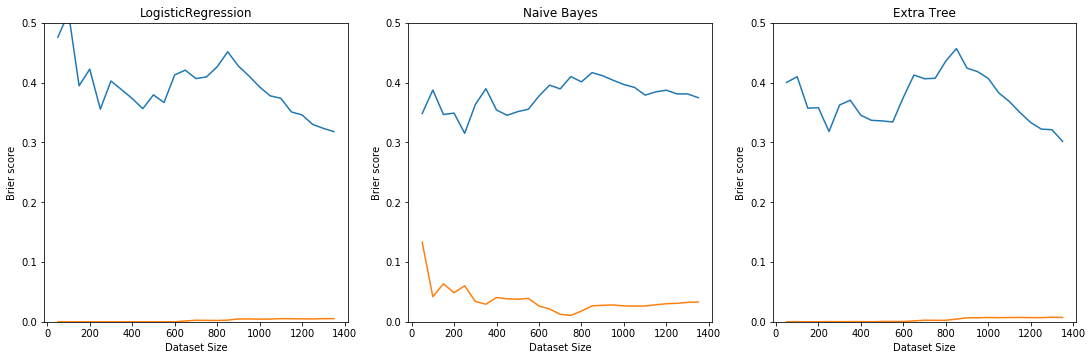

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(18.5, 5.5)

lrp = sns.lineplot(train_sizes, LR_df['test_brier_score_loss'], ax=ax1)
lrp = sns.lineplot(train_sizes, LR_df['train_brier_score_loss'], ax=ax1)
lrp.set(xlabel='Dataset Size', ylabel='Brier score')
lrp.set_title('LogisticRegression')
lrp.set_ylim(ymin=0, ymax=0.5)

nbp = sns.lineplot(train_sizes, NB_df['test_brier_score_loss'], ax=ax2)
nbp = sns.lineplot(train_sizes, NB_df['train_brier_score_loss'], ax=ax2)
nbp.set(xlabel='Dataset Size', ylabel='Brier score')
nbp.set_title('Naive Bayes')
nbp.set_ylim(ymin=0, ymax=0.5)

etp = sns.lineplot(train_sizes, ET_df['test_brier_score_loss'], ax=ax3)
etp = sns.lineplot(train_sizes, ET_df['train_brier_score_loss'], ax=ax3)
etp.set(xlabel='Dataset Size', ylabel='Brier score')
etp.set_title('Extra Tree')
etp.set_ylim(ymin=0, ymax=0.5)

plt.savefig('learning_cureves.pdf', bbox_inches = "tight")

In [15]:
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]

data = {'precision': {}, 'recall' : {}, 'f1' : {},
            'tp' : {}, 'fp' : {}, 'tn' : {}, 'fn' : {}}

In [16]:
kfold = 10
rskf = RepeatedStratifiedKFold(n_splits=kfold, n_repeats=5, random_state=11)

LR_clf =  LogisticRegression(C=4.281332398719396, class_weight='balanced', penalty= 'l1', solver= 'liblinear')
NB_clf = ComplementNB()
ET_clf = ExtraTreesClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10)
clfs = [LR_clf, NB_clf, ET_clf]

for clf in clfs:
    scoring =  {'precision':'precision', 'recall':'recall', 'f1':'f1', 'tp': make_scorer(tp), 'tn': make_scorer(tn), 'fp': make_scorer(fp), 'fn': make_scorer(fn)}
    res = cross_validate(clf, X=xx, y=ya, cv=rskf, scoring=scoring, n_jobs=-1)
    for scr in scoring.keys():
                data[scr][type(clf).__name__] = res['test_' + scr].tolist()

In [18]:
precision_df = pd.DataFrame(data['precision'])
recall_df = pd.DataFrame(data['recall'])
f1_df = pd.DataFrame(data['f1'])

In [23]:
i = 0
for val in ya:
    if val > 0:
        i = i + 1
print('trues:', i)
print('falses:', len(ya)-i)
print(len(ya))
print(934/1367)

trues: 934
falses: 433
1367
0.6832479882955377


In [20]:
df = pd.DataFrame(columns=['LogisticRegression', 'MultinomialNB', 'ExtraTrees'],
                  index=['Precision', 'PrecisionVariance', 'Recall', 'RecallVariance', 'f1', 'f1Variance'])
df['LogisticRegression'] = [np.mean(precision_df['LogisticRegression']), np.var(precision_df['LogisticRegression']),
                            np.mean(recall_df['LogisticRegression']), np.var(recall_df['LogisticRegression']),
                            np.mean(f1_df['LogisticRegression']), np.var(f1_df['LogisticRegression'])]

df['MultinomialNB'] = [np.mean(precision_df['ComplementNB']), np.var(precision_df['ComplementNB']),
                            np.mean(recall_df['ComplementNB']), np.var(recall_df['ComplementNB']),
                            np.mean(f1_df['ComplementNB']), np.var(f1_df['ComplementNB'])]

df['ExtraTrees'] = [np.mean(precision_df['ExtraTreesClassifier']), np.var(precision_df['ExtraTreesClassifier']),
                            np.mean(recall_df['ExtraTreesClassifier']), np.var(recall_df['ExtraTreesClassifier']),
                            np.mean(f1_df['ExtraTreesClassifier']), np.var(f1_df['ExtraTreesClassifier'])]

df

,LogisticRegression,MultinomialNB,ExtraTrees
Precision,0.732073,0.757195,0.715946
PrecisionVariance,0.000310,0.000942,0.000175
Recall,0.855671,0.659380,0.921624
RecallVariance,0.001834,0.003157,0.000803
f1,0.788647,0.703908,0.805660
f1Variance,0.000573,0.001567,0.000225


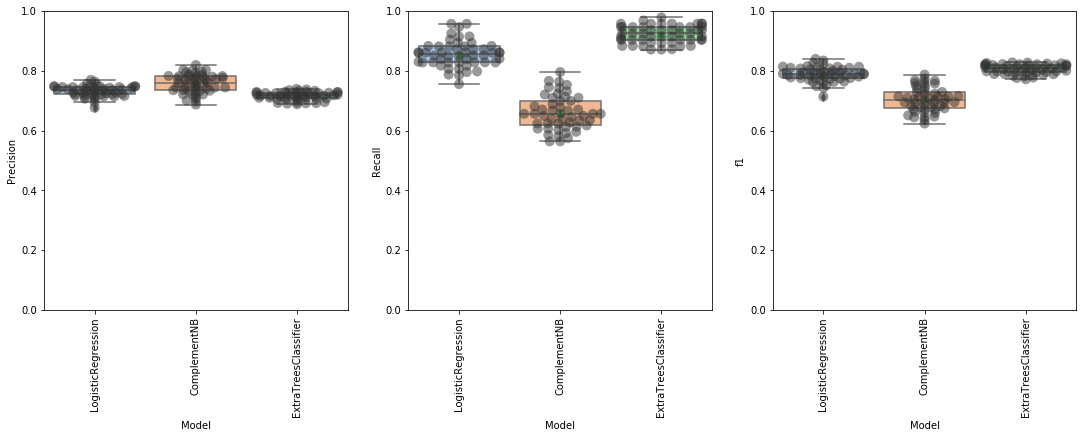

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(18.5, 5.5)

axp = sns.boxplot(data=precision_df, showmeans=True, palette="pastel", ax=ax1)
axp = sns.swarmplot(data=precision_df, size=10, orient="v", color='.2', alpha=0.5, ax=ax1)
axp.set(xlabel='Model', ylabel='Precision')
axp.set_xticklabels(axp.get_xticklabels(),rotation=90)
axp.set_ylim(0,1)

axr = sns.boxplot(data=recall_df, showmeans=True, palette="pastel", ax=ax2)
axr = sns.swarmplot(data=recall_df, size=10, orient="v", color='.2', alpha=0.5, ax=ax2)
axr.set(xlabel='Model', ylabel='Recall')
axr.set_xticklabels(axp.get_xticklabels(),rotation=90)
axr.set_ylim(0,1)

axf = sns.boxplot(data=f1_df, showmeans=True, palette="pastel", ax=ax3)
axf = sns.swarmplot(data=f1_df, size=10, orient="v", color='.2', alpha=0.5, ax=ax3)
axf.set(xlabel='Model', ylabel='f1')
axf.set_xticklabels(axp.get_xticklabels(),rotation=90)
axf.set_ylim(0,1)

plt.savefig('modelcomparison_1.pdf', bbox_inches = "tight")